In [1]:
import pandas as pd
from matplotlib import pyplot as plt
import numpy as np
import requests
import json
from clint.textui import progress

def get_keys(path):
    with open(path) as f:
        return json.load(f)
        
keys = get_keys(r'C:\Users\Santiago Arce\.secret\api_keys.txt')
fred = str(keys['FRED']).strip('<>')
print(fred)


89439cb15b97cd794bce7b892a3482fd


## Getting and cleaning data

In [2]:
#needed later even in case None
def funky_log(inp):
    if inp == None:
        return None
    else:
        return np.log(inp)

for ast in asset_list:
    try:
        url = 'https://api.stlouisfed.org/fred/series/observations?series_id='+ast+'&realtime_start=2022-01-01&realtime_end=9999-12-31&observation_start=2015-01-01&observation_end=9999-12-31&api_key='+fred+'&file_type=json&limit=10000'
        r = requests.get(url).json()['observations']
        srs = []
        for dict in r:
            val = (dict['value'])
            if val == '.':
                srs.append(None)
            else: 
                srs.append(float(val.replace(' .', '.')))
    
        logsrs = list(map(funky_log, srs))
        dlogsrs = [None]
        for i in range(len(srs)-1):
            if logsrs[i+1] != None and logsrs[i] != None:
                dlogsrs.append(logsrs[i+1]-logsrs[i])
            else:
                dlogsrs.append(None)
                
        data.append(srs)
        data.append(dlogsrs)
                
    except Exception as X:
        print(X)

In [3]:
#the way it was collected the data cannot be used we need to transpose it
def transpose(matrix):
    out = []
    for i in range(len(matrix[0])):
        l = []
        for j in range(len(matrix)):
            l.append(matrix[j][i])
        out.append(l)
    return out
#the data can only be transposed if it is rectangular
def trim_bangs(matrix_with_bangs):
    out = []
    m = int(min(map(len, data)))
    for i in range(len(matrix_with_bangs)):
        l = matrix_with_bangs[i][:m]
        out.append(l)
    return out

data = transpose(trim_bangs(data))

In [4]:
df = pd.DataFrame(data, columns = headers)
df.head()

,VIXCLS,VIXCLS (ln diff),WILL5000PR,WILL5000PR (ln diff),BAMLC0A4CBBBEY,BAMLC0A4CBBBEY (ln diff),DCOILBRENTEU,DCOILBRENTEU (ln diff),WILLREITIND,WILLREITIND (ln diff)
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,17.79,NaN,21279.35,NaN,3.78,NaN,55.38,NaN,8657.88,NaN
2,19.92,0.113088,20901.76,-0.017904,3.76,-0.005305,51.08,-0.080825,8704.96,0.005423
3,21.12,0.058496,20704.25,-0.009494,3.73,-0.008011,50.12,-0.018973,8792.16,0.009967
4,19.31,-0.089597,20945.10,0.011566,3.71,-0.005376,49.06,-0.021376,8928.12,0.015345


In [ ]:
#here I formerly made a permanent csv with this data but now access is denied and it is not needed so i don't include the code

In [6]:
#Impute-->Turn into something for LSTM-->Split data to train an test
from sklearn.impute import KNNImputer

#IMPUTATION SUPER SHADY ACTUALLY DID NOT WORK BY WHAT IT SEEMS
imputer = KNNImputer(n_neighbors=2, weights="uniform")
df_inp = pd.DataFrame(imputer.fit_transform(data), columns = headers)
df_inp.head()

,VIXCLS,VIXCLS (ln diff),WILL5000PR,WILL5000PR (ln diff),BAMLC0A4CBBBEY,BAMLC0A4CBBBEY (ln diff),DCOILBRENTEU,DCOILBRENTEU (ln diff),WILLREITIND,WILLREITIND (ln diff)
0,18.672608,-0.001235,31654.404042,0.000383,3.789884,0.000197,63.907573,0.000226,10815.252295,0.000169
1,17.790000,0.030272,21279.350000,-0.006831,3.780000,0.002688,55.380000,0.006373,8657.880000,-0.001885
2,19.920000,0.113088,20901.760000,-0.017904,3.760000,-0.005305,51.080000,-0.080825,8704.960000,0.005423
3,21.120000,0.058496,20704.250000,-0.009494,3.730000,-0.008011,50.120000,-0.018973,8792.160000,0.009967
4,19.310000,-0.089597,20945.100000,0.011566,3.710000,-0.005376,49.060000,-0.021376,8928.120000,0.015345


In [56]:
data = df_inp.values.tolist()

In [3]:
#asset list (stock ID to make API request)
asset_listA = ['WILL5000PR', 'AAA', 'PPIACO', 'POILBREUSDM', 'CBBTCUSD']

#Volatility, Total stock index, Bonds, Oil, Real Estate
asset_listB = ['VIXCLS', 'WILL5000PR', 'BAMLC0A4CBBBEY', 'DCOILBRENTEU', 'WILLREITIND']

assetlistlist = [asset_listA, asset_listB]

asset_list = assetlistlist[1]

data = []
headers = []

for ast in asset_list:
    headers.append(ast)
    headers.append(ast+' (ln diff)')

In [4]:
#RUN FROM HERE (ALSO RUN HEADERS ABOVE)

import pandas as pd

from sklearn.impute import KNNImputer

#IMPUTATION SUPER SHADY ACTUALLY DID NOT WORK BY WHAT IT SEEMS
imputer = KNNImputer(n_neighbors=2, weights="uniform")

data = pd.read_csv(r"C:\Users\Santiago Arce\LSTM Portfolio opt\lstm_data_final.csv", index_col = None)
data.pop(data.columns[0])
data = data.values.tolist()
data = df_inp = pd.DataFrame(imputer.fit_transform(data), columns = headers)

data = data.values.tolist()

In [5]:
import sklearn
from sklearn.model_selection import train_test_split
from numpy import array

#shuffle OPTION, TEST THIS
x_train, x_test = train_test_split(data, test_size=0.33, shuffle=False)

#The validation on has no shuffle as there is no point here, this we take as an assumption.
x_test, x_validate = train_test_split(x_test, test_size = 0.33, shuffle = False)

x_train = array(x_train)
x_test = array(x_test)
x_validate = array(x_validate)

In [6]:
chunk_size = int(50)

In [7]:
#just gonna use this copied and pasted from ML Mastery.com because the input sizes are being retarded and nothing will work.
from numpy import array

def split_sequences(sequences, n_steps):
     X, y = list(), list()
     for i in range(len(sequences)):
         # find the end of this pattern
         end_ix = i + n_steps
         # check if we are beyond the dataset
         if end_ix > len(sequences)-1:
             break
         # gather input and output parts of the pattern
         seq_x, seq_y = sequences[i:end_ix, :], sequences[end_ix, :]
         X.append(seq_x)
         y.append(seq_y)
     return array(X), array(y)

x_train, y_train = split_sequences(x_train, chunk_size)
x_test, y_test = split_sequences(x_test, chunk_size)
x_validate, y_validate = split_sequences(x_validate, chunk_size)

In [8]:
import numpy as np
ty_true = np.concatenate((y_train,y_validate,y_test))
ty_true.shape

(2122, 10)

In [9]:
x_train.shape

(1472, 50, 10)

## Model 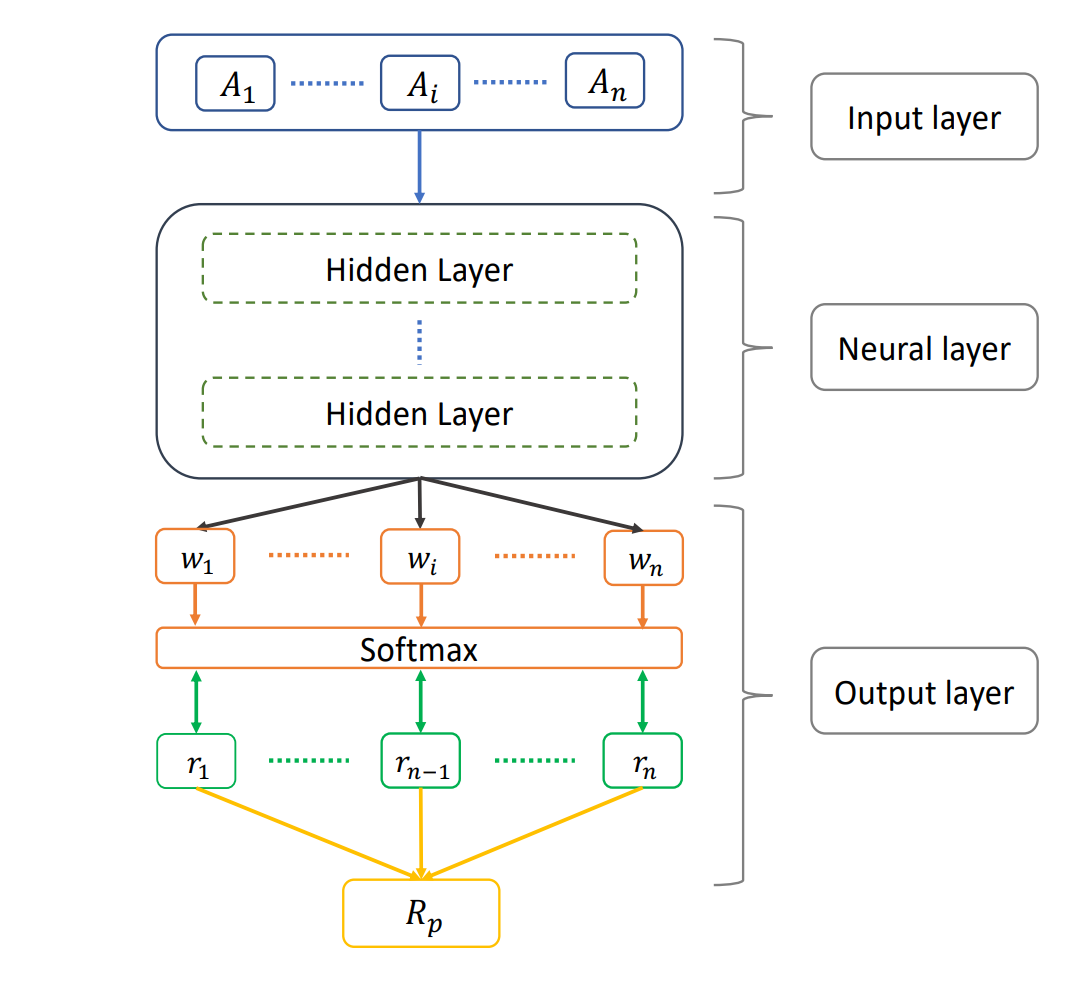 

In [10]:
import numpy as np
import random
import os
import tensorflow as tf


def set_seed(seed_value):
    random.seed(seed_value)
    np.random.seed(seed_value)
    os.environ["PYTHONHASHSEED"] = str(seed_value)
    

SEED = 42
set_seed(SEED)

In [11]:
ty_true_mod = ty_true[:,::2]

In [12]:
#running something as sanity check: equal weights: see how it compares
import numpy as np
import sys

arr = [
    [1,2,3, 4, 5],
    [6, 7, 8, 9, 10],
    [11,12,13,-2,15]
]

#m = tf.cast(tf.constant(arr), tf.float32)

for i in range(18,20):
    sample = i
    
    m = tf.cast(tf.constant(x_trial[sample]),tf.float32)
    ypred = tf.constant([0.2,0.2,0.2,0.2,0.2])
    yt = tf.cast(tf.constant(y_test)[sample,::2],tf.float32)
    r, v, s = inv_sharpe(m, yt, ypred)
    with tf.compat.v1.Session() as sess:
        r = sess.run(r)
        v = sess.run(v)
        s= sess.run(s)

        print(r, v, s)

NameError: name 'x_trial' is not defined

In [24]:
import tensorflow as tf
import keras

@tf.function
def hwhere(t1, t2):
    n = t1.shape[0]
    index = -1
    for i in range(n):
        if tf.reduce_all(tf.equal(t1[i,:], t2)):
            index = i
    return index     

#returns inverse sharpe ratio 
def inv_sharpe(matrix, y_true, y_pred):
    #getting only stocks not log returns
    yt = y_true#[:,::2]
    m = matrix#[:,::2]
    
    #calculates covariance (c) of m with the rows taken as the variables and columns taken as the instances
    try:
        mean = tf.reduce_mean(m, 0, True, None)
        centered_input = m - mean
    except:
        print('mean')

    try:
        c = tf.cast(tf.matmul(tf.transpose(centered_input), centered_input), tf.float32)/ tf.cast(tf.shape(m)[0]-1, tf.float32)
    except:
        print('c')
        
    #calculates portfolio variance (v) as wT c w
    try:
        temp = tf.linalg.matvec(c, y_pred)
    except:
        print('matvec')

    try:
        v = tf.reduce_sum(y_pred*temp)
    except:
        print('sum')
    
    #calculates returns (r) as wT R
    r = tf.math.abs(tf.reduce_sum(y_pred*(yt- m[0,:])))

    #sharpe^-1 = variance/returns
    try:
        #s = tf.math.exp(-1*(r/v))
        #s = tf.math.divide(tf.math.sqrt(v), tf.math.abs(r))
        s = -1*tf.math.abs((r/tf.math.sqrt(v)))
    except:
        s = 0
        print('s')
        
    return s

@keras.saving.register_keras_serializable()
class sharpe(keras.losses.Loss):
    def __init__(self, input, y, name="sharpe_loss"):
        super().__init__(name=name)
        self.input = input
        self.y = tf.cast(tf.constant(y),tf.float32)

    def call(self, y_true, y_pred):
        i = hwhere(self.y, y_true)
        current_data_point = self.input[i]
        return inv_sharpe(current_data_point, y_true, y_pred)

    def get_config(self):
        return {
            "input": self.input,
            "y": self.y,
            "name": self.name,
        }

In [14]:
#If using modified training data, make sure to update loss function as well.

x_train_mod = x_train[:,:, ::2]
y_train_mod = y_train[:, ::2]
x_validate_mod = x_validate[:,:, ::2]
y_validate_mod = y_validate[:, ::2]

x_train_mod.shape
y_train_mod.shape

(1472, 5)

In [25]:
import tensorflow as tf
import keras
from keras.models import Model
from keras.layers import Input, Dense, Softmax, LSTM, Flatten
from keras import backend as K
from tensorflow.python.framework.ops import disable_eager_execution

disable_eager_execution()

inputs = Input(shape=(chunk_size,5), name="digits")
lstm1 = LSTM(units=32, return_sequences=True)(inputs)
lstm2 = LSTM(units=32)(lstm1)
outputs = Dense(units=5, activation="softmax", name="predictions")(lstm2)

model = keras.Model(inputs=inputs, outputs=outputs)

model.compile(optimizer='adam', loss=sharpe(inputs, ty_true_mod))
print(model.summary())

Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 digits (InputLayer)         [(None, 50, 5)]           0         
                                                                 
 lstm_6 (LSTM)               (None, 50, 32)            4864      
                                                                 
 lstm_7 (LSTM)               (None, 32)                8320      
                                                                 
 predictions (Dense)         (None, 5)                 165       
                                                                 
Total params: 13349 (52.14 KB)
Trainable params: 13349 (52.14 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
None


In [26]:
history = model.fit(x_train_mod, y_train_mod, epochs = 200, validation_data = (x_validate_mod, y_validate_mod), verbose = 2)

Train on 1472 samples, validate on 198 samples
Epoch 1/200


KeyboardInterrupt: 

In [27]:
#now with -sharpe not inv sharpe as the loss
history = model.fit(x_train_mod, y_train_mod, epochs = 3000, validation_data = (x_validate_mod, y_validate_mod), verbose = 2)

Train on 1472 samples, validate on 198 samples
Epoch 1/3000
1472/1472 - 70s - loss: -2.4655e+01 - val_loss: -7.3281e+00 - 70s/epoch - 48ms/sample
Epoch 2/3000
1472/1472 - 2s - loss: -3.0698e+01 - val_loss: -7.0971e+00 - 2s/epoch - 1ms/sample
Epoch 3/3000
1472/1472 - 2s - loss: -3.2194e+01 - val_loss: -6.6101e+00 - 2s/epoch - 1ms/sample
Epoch 4/3000
1472/1472 - 2s - loss: -4.1310e+01 - val_loss: -1.3560e+01 - 2s/epoch - 1ms/sample
Epoch 5/3000
1472/1472 - 2s - loss: -3.9083e+01 - val_loss: -1.2534e+01 - 2s/epoch - 1ms/sample
Epoch 6/3000
1472/1472 - 2s - loss: -4.2115e+01 - val_loss: -1.0642e+01 - 2s/epoch - 1ms/sample
Epoch 7/3000
1472/1472 - 2s - loss: -3.9491e+01 - val_loss: -1.1290e+01 - 2s/epoch - 1ms/sample
Epoch 8/3000
1472/1472 - 2s - loss: -3.9393e+01 - val_loss: -8.5458e+00 - 2s/epoch - 1ms/sample
Epoch 9/3000
1472/1472 - 2s - loss: -3.4757e+01 - val_loss: -7.8058e+00 - 2s/epoch - 1ms/sample
Epoch 10/3000
1472/1472 - 2s - loss: -4.1895e+01 - val_loss: -9.8753e+00 - 2s/epoch - 

<Axes: >

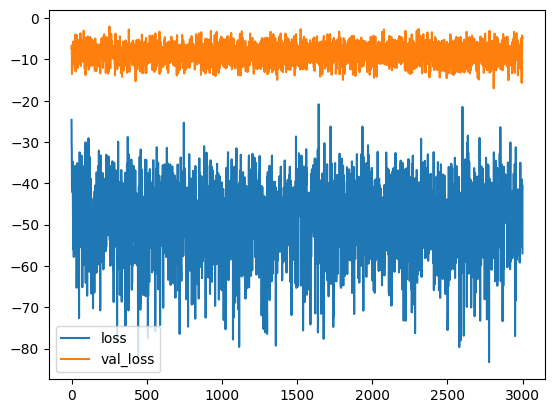

In [28]:
import pandas as pd
history_frame = pd.DataFrame(history.history)
history_frame.loc[:, ['loss', 'val_loss']].plot()

In [29]:
x_trial = x_test[:,:,::2]
y_trial = y_test[:,::2]

In [30]:
yhat = model.predict(x_trial)
print(yhat)

C:\Users\Santiago Arce\Lib\site-packages\keras\src\engine\training_v1.py:2359: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,


[[1.1273199e-01 9.9239254e-04 8.8623106e-01 5.7152053e-13 4.4566914e-05]
 [1.1273199e-01 9.9239254e-04 8.8623106e-01 5.7152053e-13 4.4566914e-05]
 [1.1273199e-01 9.9239254e-04 8.8623106e-01 5.7152053e-13 4.4566914e-05]
 ...
 [1.1273199e-01 9.9239254e-04 8.8623106e-01 5.7152053e-13 4.4566914e-05]
 [1.1273199e-01 9.9239254e-04 8.8623106e-01 5.7152053e-13 4.4566914e-05]
 [1.1273199e-01 9.9239254e-04 8.8623106e-01 5.7152053e-13 4.4566914e-05]]


In [32]:
import numpy as np

x_trial[0].shape

(50, 5)

In [37]:
#running something as sanity check: equal weights: see how it compares
import numpy as np
import random

sharpesml = []
sharpesct = []

for i in range(x_trial.shape[0]):
    
    sample = i
    
    m = x_trial[sample]
    cove = np.cov(np.transpose(m))
    diff = np.array([(y_test[sample,j]-m[0,j]) for j in range(x_trial.shape[-1])])
    weights = [random.random() for i in range(5)]
    
    weights = np.array([e/sum(weights) for e in weights])
    mlweights = yhat[sample]
    
    r1 = np.sum(diff[i]*weights[i] for i in range(diff.shape[0]))
    v1 = 0
    
    for i in range(cove.shape[0]):
        for j in range(cove.shape[0]):
            v1 = v1 + weights[i]*weights[j]*cove[i,j]

    s1 = r1/np.sqrt(v1)
    
    r2, v2 = 0, 0
    for j in range(cove.shape[0]):
        for k in range(cove.shape[0]):
            v2 = v2 + mlweights[j]*mlweights[k]*cove[j,k]
        r2 = r2+ weights[j]*diff[k]
    
    s2 = r2/np.sqrt(v2)

    print(s1, s2)
    
    sharpesct.append(s1)
    sharpesml.append(s2)

-23.411989535762377 -7856.807584317802
49.54366578511984 -8209.368040756362
-17.598053248511327 -8273.295448576451
-19.418697748938 -8389.735071839395
-8.757330267428001 -8340.484178640778
-9.386061749954948 -8884.847799317207
82.32206033274055 -8813.253157078489
15.482203701016934 -8933.563076754072
-8.418483159098543 -8842.667315720995
60.83016308425993 -9204.528805277578
-10.670752220149387 -9424.176670131863
-28.979392388546046 -8990.801634790972
-5.504313143770328 -8805.009114097038
-15.82017447602653 -8860.467946846542
20.848062439136825 -8954.497478319741
-15.298021102654872 -9185.348858266289
10.785924899928636 -9162.23055397488
-19.420300617090152 -9233.759602513523
-8.06791083243219 -10896.081079498823
9.25505650239999 -10590.229408080642
2.246942558829825 -10542.67340277098
42.82073518126133 -10767.156624137338
22.607023564877682 -10667.336281270138
100.8846404586509 -10737.128509822176
403.1574191856219 -10976.755216308873
268.01260544829637 -10832.755957210627
-18.54746952

C:\Users\Santiago Arce\AppData\Local\Temp\ipykernel_23416\4291707140.py:20: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  r1 = np.sum(diff[i]*weights[i] for i in range(diff.shape[0]))


In [39]:
print(np.array(sharpesct).std())

75.00395554701876


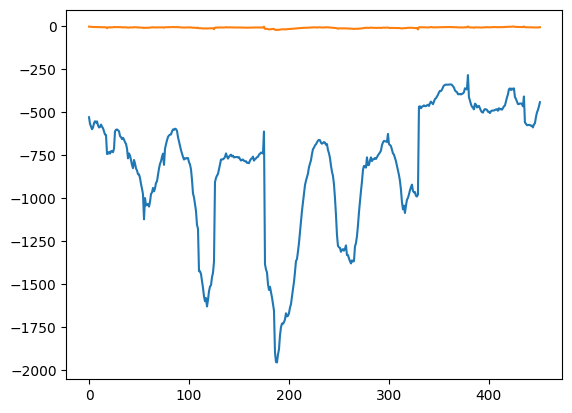

In [71]:
from matplotlib import pyplot as plt
import numpy as np

plt.plot(sharpesml)
plt.plot(sharpesct)

In [ ]:
import tensorflow as tf
import keras
from keras.models import Model
from keras.layers import Input, Dense, Softmax, LSTM, Flatten
from keras import backend as K
from tensorflow.python.framework.ops import disable_eager_execution
from sklearn.model_selection import GridSearchCV


disable_eager_execution()

inputs = Input(shape=(chunk_size,5), name="digits")
lstm1 = LSTM(units=32, return_sequences=True)(inputs)
lstm2 = LSTM(units=32)(lstm1)
outputs = Dense(units=5, activation="softmax", name="predictions")(lstm2)

best_model = keras.Model(inputs=inputs, outputs=outputs)

parameters = {
    "dropout": [5, 10, 15, 20, 25], 
    "": [3, 5, 7, 9, 11, 13],
}

best_model = GridSearchCV(
    batch size:,
    units:,
    best_model, 
    parameters,
)


#best_model.compile(optimizer='adam', loss=sharpe(inputs, ty_true_mod))
#print(model.summary())

best_model.fit(x_train_mod, y_train_mod, epochs = 200, validation_data = (x_validate_mod, y_validate_mod), verbose = 2)

print('-----')
print(f'Best parameters {model_random_forest.best_params_}')
print(
    f'Mean cross-validated accuracy score of the best_estimator: '+ \
    f'{model_random_forest.best_score_:.3f}'
)